In [2]:
!pip install kagglehub

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alessandrasala79/ai-vs-human-generated-dataset")

print("Path to dataset files:", path)

100%|██████████| 9.76G/9.76G [01:53<00:00, 92.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/alessandrasala79/ai-vs-human-generated-dataset/versions/4


In [4]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from IPython.display import display
import seaborn as sns

In [5]:
TRAIN_CSV = path + '/train.csv'
TEST_CSV = path + '/test.csv'
DATA_DIR = path

In [6]:
train_df = pd.read_csv(TRAIN_CSV)
train_df = train_df[['file_name','label']]
train_df.columns = ['id','label']
train_df.head()

,id,label
0,train_data/a6dcb93f596a43249135678dfcfc17ea.jpg,1
1,train_data/041be3153810433ab146bc97d5af505c.jpg,0
2,train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg,1
3,train_data/8542fe161d9147be8e835e50c0de39cd.jpg,0
4,train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg,1


In [7]:
test_df = pd.read_csv(TEST_CSV)
test_df.head()

,id
0,test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg
1,test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg
2,test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg
3,test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg
4,test_data_v2/a16495c578b7494683805484ca27cf9f.jpg


In [8]:
print('Train set: ', len(train_df))
print('Test set: ', len(test_df))

Train set:  79950
Test set:  5540


Check for completeness

In [9]:
print("Train null counts: ")
print(train_df.isnull().sum())
print("Test null counts: ")
print(test_df.isnull().sum())

Train null counts: 
id       0
label    0
dtype: int64
Test null counts: 
id    0
dtype: int64


Check for file existence

In [10]:
def check_file_existence(df):
  missing = []
  for fname in df['id']:
    if not os.path.isfile(os.path.join(DATA_DIR, fname)):
      missing.append(fname)
  return missing
train_missing = check_file_existence(train_df)
test_missing = check_file_existence(test_df)

print(f'Missing train: {len(train_missing)}/{len(train_df)}')
print(f'Missing test: {len(test_missing)}/{len(test_df)}')

Missing train: 0/79950
Missing test: 0/5540


In [11]:
train_df['pair_id'] = train_df.index //2
train_df.head()

,id,label,pair_id
0,train_data/a6dcb93f596a43249135678dfcfc17ea.jpg,1,0
1,train_data/041be3153810433ab146bc97d5af505c.jpg,0,0
2,train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg,1,1
3,train_data/8542fe161d9147be8e835e50c0de39cd.jpg,0,1
4,train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg,1,2


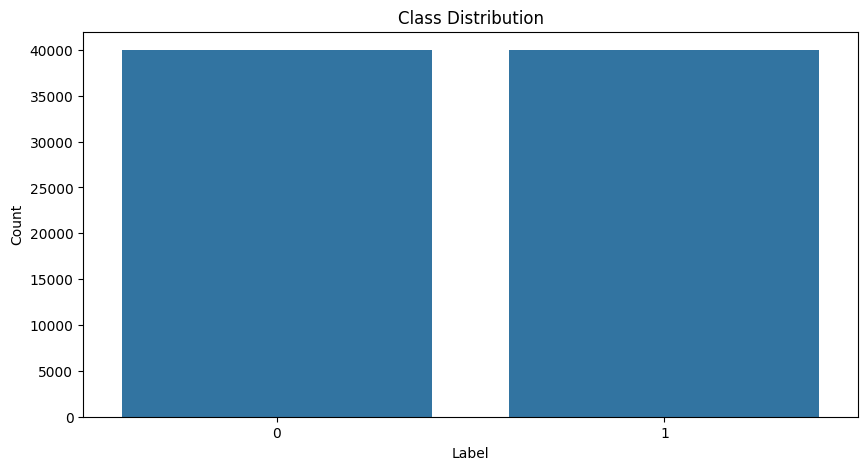

In [13]:
# Class balance
label_counts = train_df["label"].value_counts()
plt.figure(figsize=(10, 5))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Class Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

In [20]:
pair_violations = sum(train_df['label'].diff()[1::2]!= -1) # think of it as if there are 2 of the same labels next to each other it would be 0
print(f'Pairing violations: {pair_violations}/{len(train_df)//2}')

Pairing violations: 0/39975


In [21]:
# Pair completeness check
pair_sizes = train_df.groupby("pair_id")["id"].count().value_counts()
print("\nPair size distribution:")
print(pair_sizes)


Pair size distribution:
id
2    39975
Name: count, dtype: int64


--> K fold cross validation and Binary Cross-Entropy